In [220]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import networkx as nx
import numpy as np
import os
import random
from matplotlib import pyplot as plt


class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        #invert_reward = True
        reward = 0
        while True:
            #print(node.to_pretty_string())
            if node.is_terminal():
                return reward
            node = node.find_random_child()
            reward = node.get_reward()

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


In [221]:
class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

#     @abstractmethod
#     def reward(self):
#         "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
#         return 0

#     @abstractmethod
#     def __hash__(self):
#         "Nodes must be hashable"
#         return 123456789

#     @abstractmethod
#     def __eq__(node1, node2):
#         "Nodes must be comparable"
#         return True

In [242]:
#generate random graph of preset size
def generate_graph(vertices):
    return nx.generators.random_graphs.gnp_random_graph(vertices,
                np.random.uniform(0,0.5))

In [243]:
class VertexCoverInstance(Node):
    def __init__(self, graph, cover = [], reward = 0):
        self.graph = graph
        self.cover = cover
        self.reward = reward
        
    def find_children(self):
        possiblemoves = []
        if self.is_terminal():  # If the game is finished then no moves can be made
            return set(possiblemoves)
        for i in list(self.graph.nodes):
            H = self.graph.copy()
            neigh = H.neighbors(i)
            step_reward = -1
            H.remove_node(i)
            possiblemoves.append(VertexCoverInstance(H, self.cover+[i], self.reward+step_reward))
        return set(possiblemoves)

    def find_random_child(self):
        if self.is_terminal():
            return None  # If the game is finished then no moves can be made
        temp = self.find_children()
        return random.sample(temp,1)[0]

#     def reward(board):
#         if not board.terminal:
#             raise RuntimeError(f"reward called on nonterminal board {board}")
#         return self.reward #reward comes upon reaching terminal state

    def is_terminal(self):
        return nx.classes.function.is_empty(self.graph)

    def to_pretty_string(self):
        return str(list(self.graph.nodes()))
    
    def get_cover(self):
        return str(self.cover)
    
    def get_reward(self):
        return self.reward
    

In [308]:
def play_game(G, display = True):
    tree = MCTS()
    board = VertexCoverInstance(G)
    #print(board.to_pretty_string())
    moves = 0
    while True:
        if board.is_terminal():
            break
        #80 rollouts per turn
        for _ in range(80):
            tree.do_rollout(board)
        board = tree.choose(board)
        #print(board.to_pretty_string())
        moves = moves+1
        if board.is_terminal():
            break
            
    vc = board.get_cover()
    if display:
        print("\n\nMCTS APPROX\n")
        print(vc)
        color_map = []
        for node in G:
            if str(node) in vc:
                color_map.append('red')
            else: 
                color_map.append('blue')  
        plt.figure(1)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return vc, moves

In [309]:
from networkx.algorithms import approximation as appx
import itertools

def show_optimal_vc(G, display=True):
    #opt = list(appx.vertex_cover.min_weighted_vertex_cover(G))
    def findsubsets(s): 
        lists =[list(itertools.combinations(s, n)) for n in range(len(s))]
        return list(itertools.chain.from_iterable(lists))
    
    powerset = findsubsets(list(G.nodes()))    
    for s in powerset:
        H = G.copy()
        H.remove_nodes_from(s)
        if nx.classes.function.is_empty(H):
            opt = list(s)
            break
    if display:
        print("\n\nOPTIMAL\n")
        print(opt)
        color_map = []
        for node in G:
            if node in opt:
                color_map.append('orange')
            else: 
                color_map.append('green')
        plt.figure(2)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return opt



MCTS APPROX

[7, 4, 0, 3, 5, 8]



OPTIMAL

[0, 1, 3, 4, 6, 9]


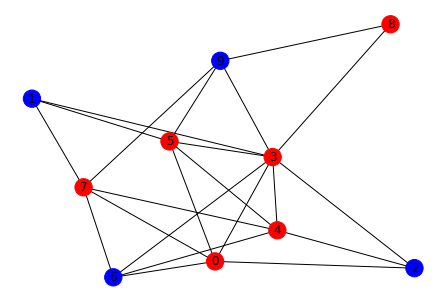

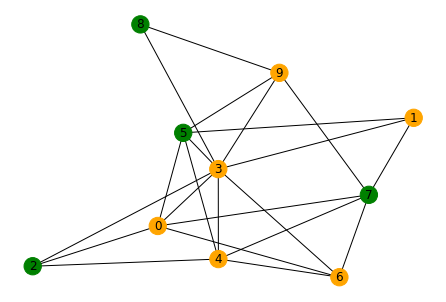

In [312]:
G = generate_graph(10)
vc, moves = play_game(G)
print()
opt = show_optimal_vc(G)

457


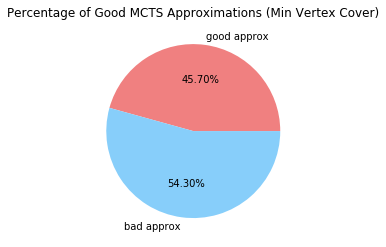

In [314]:
NUM_SIMS = 1000

def sim_test_approx(simulations):
    count_success = 0
    for x in range(simulations):
        A = generate_graph(10)
        vc, moves = play_game(A, display=False)
        opt = show_optimal_vc(A, display=False)
        if moves<=len(opt)*1.1:
            count_success=count_success+1
    print(count_success)
    return count_success

count = sim_test_approx(NUM_SIMS)
plot_arr = [count,NUM_SIMS-count]
plt.figure(3)
plt.pie(plot_arr, colors = ['lightcoral','lightskyblue'], labels = ['good approx', 'bad approx'],autopct='%1.2f%%')
plt.title('Percentage of Good MCTS Approximations (Min Vertex Cover)')
plt.show()

    